Comparison of DnCNN Variants for Image Denoising
================================================

This example demonstrates the solution of an image denoising problem
using different DnCNN <cite data-cite="zhang-2017-dncnn"/> variants with different
numbers of layers and trained for different noise levels. In addition,
a non-blind variant with a noise level input (as in
<cite data-cite="zhang-2021-plug"/>, but using a different network architecture)
is included.

The labels of the blind denoising variants are 6L, 6M, 6H, 17L, 17M, and
17H where the numeric prefix denotes the number of layers, and the alpha
postfixes L, M, and H denote training for low, medium, and high noise
levels respectively. The 6N and 17N variants are the non-blind forms with
a noise level input.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.random
from scico import metric, plot
from scico.denoiser import DnCNN

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Test different DnCNN variants on images with different noise levels

In [3]:
print("  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)")
for σ in [0.06, 0.1, 0.2]:
    print("------+---------+-------------------------+-------------------------")
    for variant in ["17L", "17M", "17H", "17N", "6L", "6M", "6H", "6N"]:

        # Instantiate a DnCnn
        denoiser = DnCNN(variant=variant)

        # Generate a noisy image.
        noise, key = scico.random.randn(x_gt.shape, seed=0)
        y = x_gt + σ * noise

        if variant in ["6N", "17N"]:
            x_hat = denoiser(y, sigma=σ)
        else:
            x_hat = denoiser(y)

        x_hat = np.clip(x_hat, a_min=0, a_max=1.0)

        if variant[0] == "6":
            variant += " "  # add spaces to maintain alignment

        print(
            " %.2f | %s     |          %.2f          |          %.2f          "
            % (σ, variant, metric.psnr(x_gt, y), metric.psnr(x_gt, x_hat))
        )

  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)
------+---------+-------------------------+-------------------------
 0.06 | 17L     |          24.43          |          33.82          
 0.06 | 17M     |          24.43          |          33.94          
 0.06 | 17H     |          24.43          |          26.32          
 0.06 | 17N     |          24.43          |          35.48          
 0.06 | 6L      |          24.43          |          33.80          
 0.06 | 6M      |          24.43          |          29.76          
 0.06 | 6H      |          24.43          |          26.86          
 0.06 | 6N      |          24.43          |          36.30          
------+---------+-------------------------+-------------------------
 0.10 | 17L     |          19.99          |          27.43          
 0.10 | 17M     |          19.99          |          31.82          
 0.10 | 17H     |          19.99          |          26.44          
 0.10 | 17N     |          19.99  

Show reference and denoised images for σ=0.2 and variant=6N.

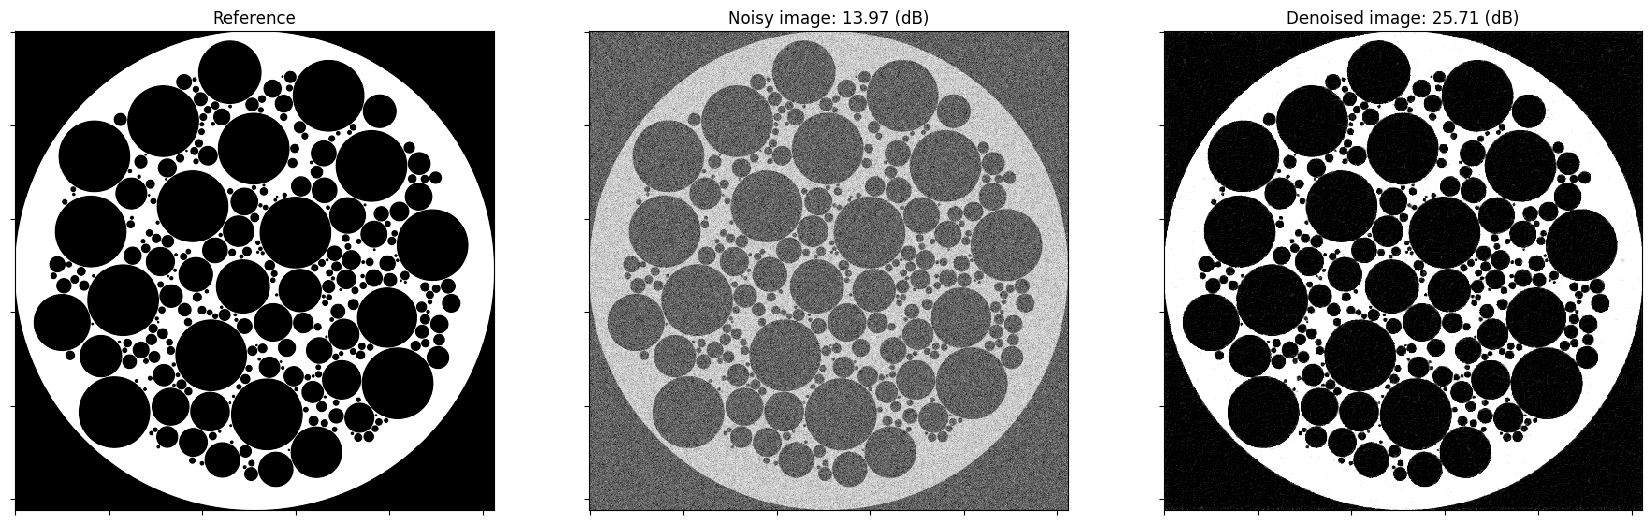

In [4]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(x_gt, title="Reference", fig=fig, ax=ax[0])
plot.imview(y, title="Noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x_hat, title="Denoised image: %.2f (dB)" % metric.psnr(x_gt, x_hat), fig=fig, ax=ax[2])
fig.show()